In [1]:
# general
import sys, os, path

# nn related
import torch
import torch as th
import torch.nn as nn
import numpy as np
from numpy import linalg as la
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# postprocessing
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# own scrips
sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans/scripts/')
import barymap as bm

# standard datatype
dtype = torch.double

**Tensor based NN**

In [2]:
class TBNN(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TBNN, self).__init__()
        self.input_layer = torch.nn.Linear(D_in, H)
        self.hidden_layer_1 = torch.nn.Linear(H, H)
        self.hidden_layer_2 = torch.nn.Linear(H, H)
        self.hidden_layer_3 = torch.nn.Linear(H, H)
        self.hidden_layer_4 = torch.nn.Linear(H, int(H/2))
        self.hidden_layer_5 = torch.nn.Linear(int(H/2), int(H/4))
        self.hidden_layer_6 = torch.nn.Linear(int(H/4), int(H/8))
        self.output_linear = torch.nn.Linear(int(H/8), D_out)
        self.NN = torch.nn.Sequential(self.input_layer,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_1,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_2,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_3,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_4,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_5,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_6,
                                      torch.nn.LeakyReLU(),
                                      self.output_linear)
        
    def forward(self, inv, T):
        G = self.NN(inv)
        G0 = G.unsqueeze(2).expand(inv.shape[0],10,9)
        return (G0*T).sum(dim=1), G

In [3]:
# N is number of input point, D_in is input size, D_out is output size, H is hidden dimension
N_ppcase = 5908  # TODO: hardcoded, change to dynamic
N_cases = 4
N_total = N_ppcase * N_cases
D_in, D_out = 5, 10
H = 200

# set path to tensordata
train_data_path = '/home/leonriccius/Documents/Fluid_Data/training_data/periodic_hills/tensordata'
# on workstation: home/leon/Master_Thesis/Fluid_Data ...
cases = os.listdir(train_data_path)
print(cases)

# initialise tensors
inv = th.zeros(N_total, 5, dtype=dtype)
T = th.zeros(N_total, 10, 9, dtype=dtype)
b = th.zeros(N_total, 3, 3, dtype=dtype)
grid = th.zeros(N_total, 2, dtype=dtype)

# loop over cases and append to tensors
for i, case in enumerate(cases):
    curr_dir = os.sep.join([train_data_path, case])
    inv[i*N_ppcase:(i+1)*(N_ppcase)] = th.load(os.sep.join([curr_dir,'inv-torch.th']))
    T[i*N_ppcase:(i+1)*(N_ppcase)] = th.load(os.sep.join([curr_dir,'T-torch.th'])).reshape(-1,10,9)
    b[i*N_ppcase:(i+1)*(N_ppcase)] = th.load(os.sep.join([curr_dir,'b-torch.th']))
    grid[i*N_ppcase:(i+1)*(N_ppcase)] = th.load(os.sep.join([curr_dir,'grid-torch.th']))

['1400', '700', '5600', '10595']


In [4]:
# create model instance
model = TBNN(D_in, H, D_out).double()
loss_fn = torch.nn.MSELoss()  # reduction='sum')

# reshape b tensor in case of own NN
b = b.flatten(1) #.float()
b.requires_grad = False

# split data into training and test data. set random_state to ensure getting same dataset for debugging
# test_size = int(N_total*0.7)%20
N_train = int(N_total*0.7) - int(N_total*0.7)%20
N_val = N_total - N_train
(inv_train, inv_val, T_train, T_val,
 b_train, b_val, grid_train, grid_val) = train_test_split(inv, T, b, grid,
                                                          test_size=N_val,
                                                          random_state=42)
inv_train.requires_grad=True

## L2 regularization
lmbda = 1e-4 # reg. constant 
def L2loss(lmbda, net):
    reg = torch.tensor(0.)
    for m in net.modules():
        if hasattr(m, 'weight'):
            reg += m.weight.norm()**2
    return lmbda*reg

**Setting up optimization parameters and starting loop**

In [5]:
# set training parameters
learning_rate = 1e-6
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # model / model.parameters() NN.turb_nn.parameters()
# niters = 10000 # int(100/learning_rate)
batchsize = 20
nepochs = 500

In [6]:
# better implementation of mini batching with disjoint mini batches

# initialize tensor to store G tensors from NN
G = torch.zeros(int(nepochs/20),inv_val.shape[0],10)

# initialize training loss
perm = np.random.permutation(inv_train.shape[0])
initial_inv = inv_train[perm[0:20]]
initial_T = T_train[perm[0:20]]
initial_b = b_train[perm[0:20]]
initial_pred, _ = model(initial_inv, initial_T)
loss_vector = loss_fn(initial_pred, initial_b).detach().numpy()

# initialize validation loss
b_val_pred, _ = model(inv_val, T_val)
val_loss_vector = loss_fn(b_val_pred, b_val).detach().numpy()

# run loop over all epochs
for epoch in range(nepochs):
    
    # random permutation of training data before every epoch
#     N_train = inv_train.shape[0]
    perm = np.random.permutation(N_train)
    batch_size = batchsize  # int(N_train/100)
    
    # loop over all batches in one epoch
    for it in range(0, N_train, batch_size):
        # get batch data
        idx = perm[np.arange(it,it + batch_size)]
        inv_batch = inv_train[idx,:]
        T_batch = T_train[idx,:,:]
        b_batch = b_train[idx,:]
        
        # Forward pass
        b_pred, _ = model(inv_batch, T_batch)
        # b_pred = NN.forward(inv_batch, T_batch.reshape(-1,10,3,3))
        
        # compute and print loss
        loss = loss_fn(b_pred, b_batch) # + L2loss(lmbda, model)
        
        # reset gradient buffer
        optimizer.zero_grad()
        
        # get gradient
        loss.backward()
        
        # optimization step
        optimizer.step()
    
    # append loss to loss vector
    loss_vector = np.append(loss_vector, loss.detach().numpy())
    
    # compute validation error
    b_val_pred, _ = model(inv_val, T_val)
    val_loss_vector = np.append(val_loss_vector, loss_fn(b_val_pred, b_val).detach().numpy())
    
    # output optimization state
    if (epoch) % 20 == 0:
        print('Epoch: {}, Training loss: {:.6f}, Validation loss {:.6f}'.format(epoch, loss.item(), val_loss_vector[-1]))
        _, G_epoch = model(inv_val, T_val)
        G[int((epoch+1)/20)] = G_epoch

Epoch: 0, Training loss: 0.031710, Validation loss 0.028289
Epoch: 20, Training loss: 0.001685, Validation loss 0.002326
Epoch: 40, Training loss: 0.003210, Validation loss 0.002266
Epoch: 60, Training loss: 0.003927, Validation loss 0.002200
Epoch: 80, Training loss: 0.003778, Validation loss 0.002121
Epoch: 100, Training loss: 0.001368, Validation loss 0.002088
Epoch: 120, Training loss: 0.002575, Validation loss 0.002068
Epoch: 140, Training loss: 0.001569, Validation loss 0.002048
Epoch: 160, Training loss: 0.001760, Validation loss 0.002028
Epoch: 180, Training loss: 0.001584, Validation loss 0.002007
Epoch: 200, Training loss: 0.002034, Validation loss 0.001985
Epoch: 220, Training loss: 0.003192, Validation loss 0.001960
Epoch: 240, Training loss: 0.001733, Validation loss 0.001937
Epoch: 260, Training loss: 0.001343, Validation loss 0.001918
Epoch: 280, Training loss: 0.001603, Validation loss 0.001900
Epoch: 300, Training loss: 0.001512, Validation loss 0.001880
Epoch: 320, Tr

In [7]:
# save G for later usage
# torch.save(G, 'tensor_data/G_10000_1e-5_tanh.th')
G.detach().numpy().shape # reshape(100,100).shape

(25, 7092, 10)

In [8]:
# save state dict for late usage. torch doc says saving state dict is better
# ensure cross platform compatibility
model_path = 'trained_models'
curr_model = '4cases'
th.save(model.state_dict(), os.sep.join([model_path, curr_model, 'state_dict.pt']))

# save whole model for later usage
th.save(model, os.sep.join([model_path, curr_model, 'model.pt']))

# save loss vector and validation loss vector for later usage
th.save(loss_vector, os.sep.join([model_path, curr_model, 'loss_vector.th']))
th.save(val_loss_vector, os.sep.join([model_path, curr_model, 'val_loss_vector.th']))

## Visualization of training process and results

**Training Process**

Text(0, 0.5, 'MSPE')

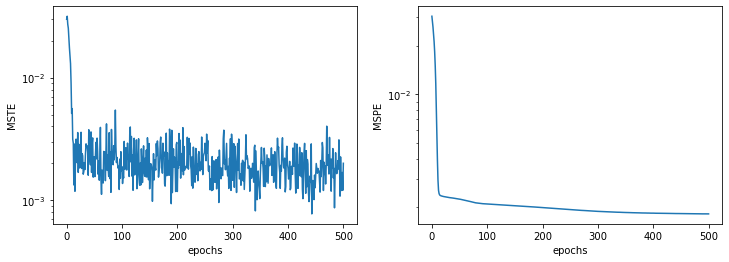

In [9]:
# plot the training and validation error
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].semilogy(np.arange(loss_vector.shape[0]), loss_vector)
ax[0].set_xlabel(r'epochs')
ax[0].set_ylabel(r'MSTE')

ax[1].semilogy(np.arange(val_loss_vector.shape[0]), val_loss_vector)
ax[1].set_xlabel(r'epochs')
ax[1].set_ylabel(r'MSPE')

In [10]:
# Output of NN (G)
# Make grid for contour plots
# fig, axs = plt.subplots(1, 5, figsize=(18,3), sharex=True, sharey=True, tight_layout=True)
# grid_x, grid_y = np.mgrid[3.:4.:100j, 1.:2.:100j]

# # loop through all saved states of G
# for i,ax in enumerate(axs.flat):
#     G_plt = ax.contourf(grid_x, grid_y, G.detach().numpy()[i,:,1].reshape(100,100))
#     fig.colorbar(G_plt, ax=ax)

### Input Data

**Invariants**

In [11]:
# visualize all invariants
# grid_x, grid_y = np.mgrid[3.:4.:30j, 1.:2.:30j]
# grid_x, grid_y = np.mgrid[1.:8.:100j, 1.:2.5:30j]
# fig, axs = plt.subplots(1,5, figsize=(20,3), sharex=True, sharey=True)

# for i in range(5):
#     grid_inv = griddata(grid, inv_scaled.detach().numpy()[:,i], (grid_x, grid_y), method='linear')
#     inv_plt = axs.flat[i].contourf(grid_x, grid_y, grid_inv)
#     fig.colorbar(inv_plt, ax=axs.flat[i])

**Tensor basis**

In [12]:
# # visualize all tensor components of the tensor basis
# grid_x, grid_y = np.mgrid[3:4:100j, 1:2:100j]

# for j in range(10):
#     fig, axs = plt.subplots(3,3, figsize=(10,8), sharex=True, sharey=True)
#     fig.suptitle(r'$T_{}$'.format(j+1), fontsize=10)
#     for i in range(9):
#         grid_z1 = griddata(grid, T.detach().numpy()[:,j,i], (grid_x, grid_y), method='linear')
#         T_plt = axs.flat[i].contourf(grid_x, grid_y, grid_z1)
#         fig.colorbar(T_plt, ax=axs.flat[i])

### Results
**anisotropy tensor $b$**

In [13]:
# load in flowcase for testing
# set path to tensordata
test_data_path = '/home/leonriccius/Documents/Fluid_Data/test_data/periodic_hills/tensordata'
cases = '2800'
curr_case = os.sep.join([test_data_path, cases])

print(curr_case)

# read in test case tensors
inv_test = th.load(os.sep.join([curr_dir,'inv-torch.th']))
T_test = th.load(os.sep.join([curr_dir,'T-torch.th'])).reshape(-1,10,9)
b_test = th.load(os.sep.join([curr_dir,'b-torch.th']))
grid_test = th.load(os.sep.join([curr_dir,'grid-torch.th']))

/home/leonriccius/Documents/Fluid_Data/test_data/periodic_hills/tensordata/2800


In [14]:
# get predicted b
b_pred, _ = model(inv_test, T_test) # .reshape(-1,9)

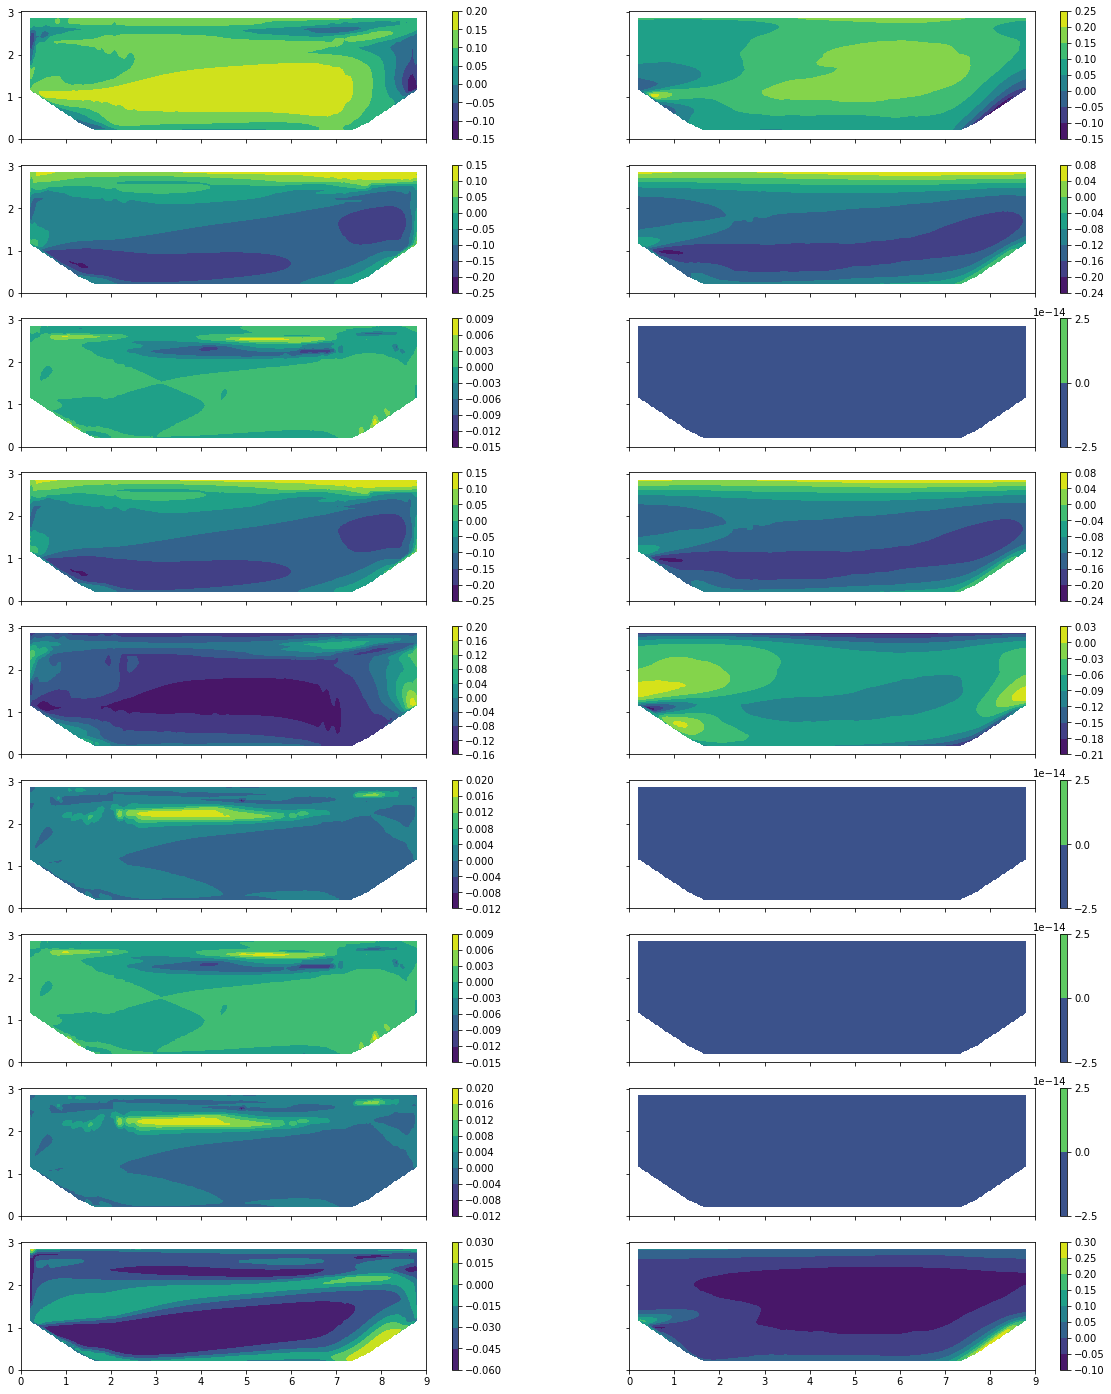

In [15]:
# visualize all tensor components of b_pred (uneven index) and b (even index)
# index runs through one line of the figure after another
grid_x, grid_y = np.mgrid[0.:9.:300j, 0.:3.035:100j]

fig, axs = plt.subplots(9,2, figsize=(20,25), sharex=True, sharey=True)

# remove flatten(1) when not using genevas NN
for i in range(9):
    grid_z1 = griddata(grid_test, b_pred.flatten(1).detach().numpy()[:,i], (grid_x, grid_y), method='linear')
    grid_z2 = griddata(grid_test, b_test.flatten(1).detach().numpy()[:,i], (grid_x, grid_y), method='linear')
    b_nn = axs.flat[2*i].contourf(grid_x, grid_y, grid_z1)
    b_dns = axs.flat[2*i+1].contourf(grid_x, grid_y, grid_z2)
    fig.colorbar(b_nn, ax=axs.flat[2*i])
    fig.colorbar(b_dns, ax=axs.flat[2*i+1])

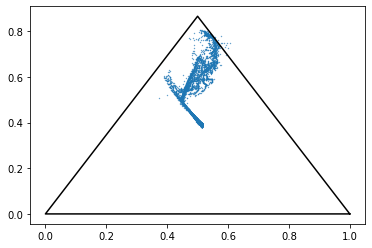

In [16]:
# barycentric map for predicted b
barm_pred = bm.BarMap()
barm_pred.load_from_variable(b_pred.reshape(-1,3,3).detach().numpy(), grid_test)
barm_pred.calculate_barycentric_coordinates()

fig, ax = plt.subplots()

barm_pred.plot_data_points(ax)
barm_pred.plot_triangle(ax)

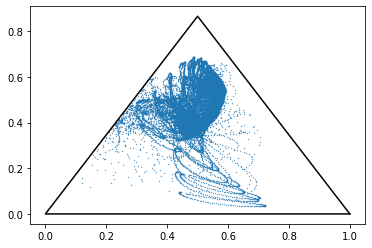

In [17]:
# barycentric map for dns b
barm = bm.BarMap()
barm.load_from_variable(b.reshape(-1,3,3).detach().numpy(), grid_test)
barm.calculate_barycentric_coordinates()

fig, ax = plt.subplots()

barm.plot_data_points(ax)
barm.plot_triangle(ax)